In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from transformers import BertTokenizer, BertModel
from datasets import load_dataset
from torch.amp import autocast, GradScaler
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datasets import concatenate_datasets

2025-05-24 05:25:31.507370: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748064331.688505      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748064331.740265      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Optional: Disable symlink warning
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load the full IMDB dataset
dataset = load_dataset("imdb")

# Print label distribution for better understanding
print("Training dataset label distribution:", dataset["train"].features["label"].names)
print("Test dataset label distribution:", dataset["test"].features["label"].names)

Using device: cuda


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Training dataset label distribution: ['neg', 'pos']
Test dataset label distribution: ['neg', 'pos']


In [3]:
# Separate the positive and negative samples from the training and test sets
positive_train_data = dataset["train"].filter(lambda example: example["label"] == 1)
negative_train_data = dataset["train"].filter(lambda example: example["label"] == 0)

positive_test_data = dataset["test"].filter(lambda example: example["label"] == 1)
negative_test_data = dataset["test"].filter(lambda example: example["label"] == 0)



# Balance the datasets by selecting an equal number of samples from both classes
balanced_train_data = concatenate_datasets([positive_train_data.select(range(2000)), negative_train_data.select(range(2000))])
balanced_test_data = concatenate_datasets([positive_test_data.select(range(400)), negative_test_data.select(range(400))])


Filter:   0%|          | 0/25000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/25000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/25000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [4]:
# Load tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenization function
def tokenize_function(example):
    return tokenizer(example["text"], padding="max_length", truncation=True, max_length=256)

print("Tokenizing...")
tokenized_train = balanced_train_data.map(tokenize_function, batched=True)
tokenized_test = balanced_test_data.map(tokenize_function, batched=True)
tokenized_train.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
tokenized_test.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Tokenizing...


Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

In [5]:
# DataLoader
train_loader = DataLoader(tokenized_train, batch_size=64, shuffle=True)
test_loader = DataLoader(tokenized_test, batch_size=64,  shuffle= False)

In [6]:
# Model definition
class BERTClassifier(nn.Module):
    def __init__(self, bert):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.fc = nn.Linear(bert.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.pooler_output
        return self.fc(cls_output)


In [7]:
model = BERTClassifier(BertModel.from_pretrained("bert-base-uncased")).to(device)



model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [8]:
# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-5)
scaler = GradScaler(device)

In [9]:
# Training the model
model.train()
train_preds = []
train_labels = []
for epoch in range(20):  # Training for 5 epochs
    total_loss = 0
    correct = 0
    total = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    for batch in loop:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].float().unsqueeze(1).to(device)

        optimizer.zero_grad()
        with autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        preds = (torch.sigmoid(outputs) > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        train_preds.extend(preds.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

        loop.set_postfix(loss=total_loss/(total/8), acc=correct/total)

Epoch 20: 100%|██████████| 63/63 [01:25<00:00,  1.36s/it, acc=0.995, loss=0.00202] 


In [10]:
# Evaluation of the model
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].float().unsqueeze(1).to(device)

        with autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
            outputs = model(input_ids, attention_mask)
            preds = (torch.sigmoid(outputs) > 0.5).float()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            correct += (preds == labels).sum().item()
            total += labels.size(0)

In [11]:
accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.8988


In [12]:
# Classification Report
print("\nClassification Report (Test Data):")
print(classification_report(all_labels, all_preds))


Classification Report (Test Data):
              precision    recall  f1-score   support

         0.0       0.92      0.87      0.90       400
         1.0       0.88      0.93      0.90       400

    accuracy                           0.90       800
   macro avg       0.90      0.90      0.90       800
weighted avg       0.90      0.90      0.90       800



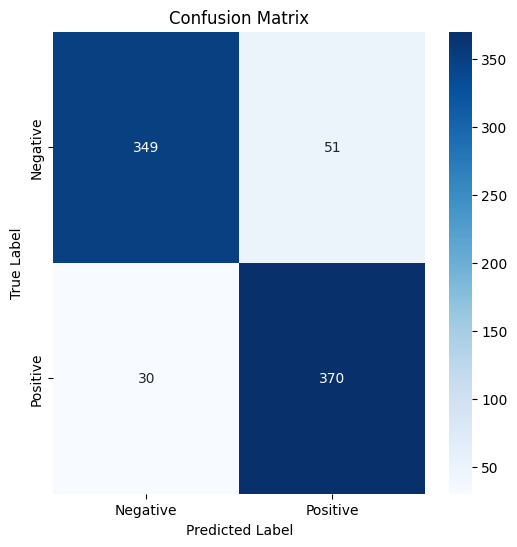

In [13]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds, labels=[0.0, 1.0])

# Plot Confusion Matrix
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

In [14]:
# Define a function to predict sentiment of custom text input
def predict_sentiment(text, model, tokenizer, device):
    model.eval()
    with torch.no_grad():
        # Tokenize input
        encoding = tokenizer(
            text,
            return_tensors='pt',
            truncation=True,
            padding='max_length',
            max_length=256
        )
        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)

        # Predict
        output = model(input_ids, attention_mask)
        prob = torch.sigmoid(output)

        # Result
        sentiment = "Positive" if prob.item() > 0.5 else "Negative"
        print(f"\nInput Text: {text}")
        print(f"Predicted Sentiment: {sentiment} (Confidence: {prob.item():.2f})")

# Example: Try predicting sentiment for new input
user_input = "Every one should watch the movie at least once"
predict_sentiment(user_input, model, tokenizer, device)

user_input = "This movie was boring and didn't make sense."
predict_sentiment(user_input, model, tokenizer, device)



Input Text: Every one should watch the movie at least once
Predicted Sentiment: Positive (Confidence: 0.86)

Input Text: This movie was boring and didn't make sense.
Predicted Sentiment: Negative (Confidence: 0.00)
